<a href="https://www.kaggle.com/code/ravaghi/handwritten-digit-recognition-with-cnn?scriptVersionId=165167334" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/digit-recognizer/sample_submission.csv
/kaggle/input/digit-recognizer/train.csv
/kaggle/input/digit-recognizer/test.csv


In [2]:
!pip install -q lightning

In [3]:
from lightning.pytorch.callbacks.early_stopping import EarlyStopping
from lightning.pytorch.callbacks import LearningRateMonitor
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from lightning import seed_everything
from torch.optim import lr_scheduler
from sklearn.manifold import TSNE
from torchmetrics import Accuracy
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torch.optim import Adam
import torch.nn as nn
import seaborn as sns
import lightning as L
import torch

seed_everything(42)
plt.style.use('ggplot')

INFO: Seed set to 42


# Loading data

In [4]:
train = pd.read_csv('/kaggle/input/digit-recognizer/train.csv')
X_test = pd.read_csv('/kaggle/input/digit-recognizer/test.csv')

In [5]:
train.shape, X_test.shape

((42000, 785), (28000, 784))

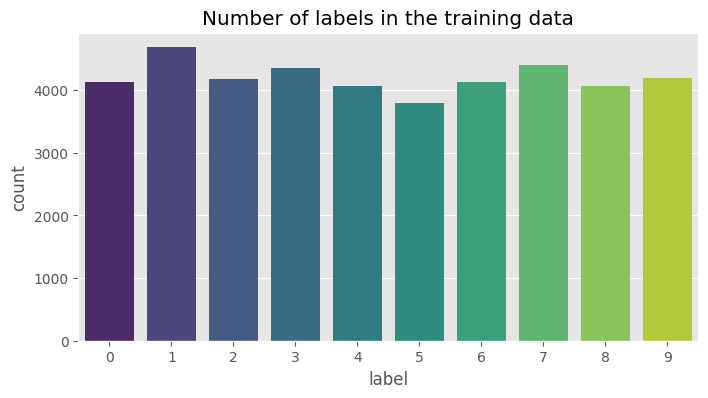

In [6]:
plt.figure(figsize=(8, 4))
sns.countplot(x="label", data=train, palette="viridis")
plt.title('Number of labels in the training data')
plt.show()

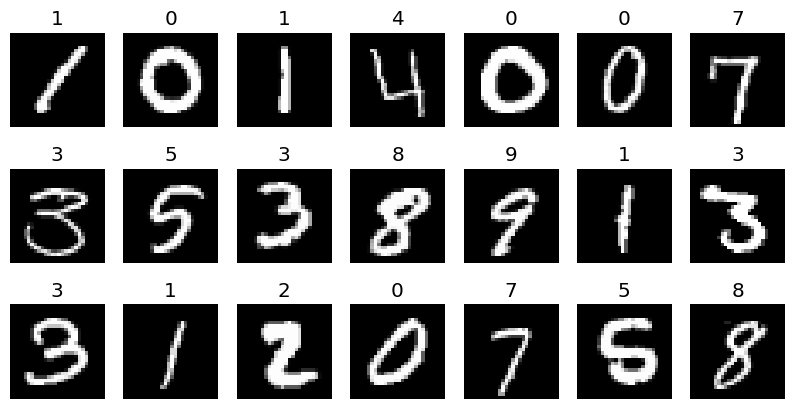

In [7]:
fig, ax = plt.subplots(3, 7, figsize=(10, 5))
for i in range(21):
    plt.subplot(3, 7, i+1)
    img = train.iloc[i, 1:].values
    img = img.reshape((28, 28))
    plt.imshow(img, cmap='gray')
    plt.title(train.iloc[i, 0])
    plt.axis('off')
plt.show()

# Visualizing with t-SNE

In [8]:
X = train.drop('label', axis=1)
y = train['label']

tsne = TSNE(
    random_state=42,
    n_components=2,
    verbose=0,
    perplexity=40,
    n_iter=300
).fit_transform(X)

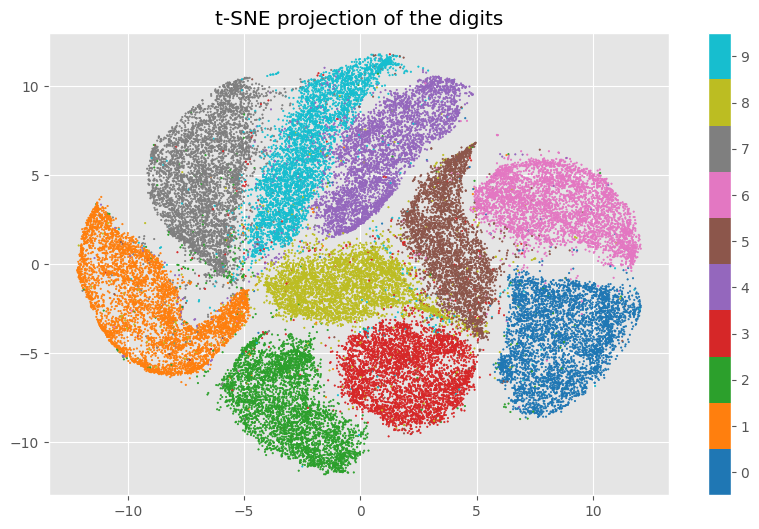

In [9]:
plt.figure(figsize=(10, 6))
plt.scatter(tsne[:, 0], tsne[:, 1], s=1, c=y, cmap='tab10')
plt.colorbar(boundaries=np.arange(11)-0.5).set_ticks(np.arange(10))
plt.title('t-SNE projection of the digits')
plt.show()

# Processing the datasets

In [10]:
X = X / 255.0
X_test = X_test / 255.0

X = X.values.reshape(-1, 1, 28, 28)
X_test = X_test.values.reshape(-1, 1, 28, 28)

X.shape, X_test.shape

((42000, 1, 28, 28), (28000, 1, 28, 28))

In [11]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.1, random_state=42)

X_train.shape, X_val.shape, y_train.shape, y_val.shape, X_test.shape

((37800, 1, 28, 28), (4200, 1, 28, 28), (37800,), (4200,), (28000, 1, 28, 28))

# Creating datamodule for training

In [12]:
class MNISTDataModule(L.LightningDataModule):
    def __init__(
        self,
        X_train: np.ndarray,
        y_train: pd.Series,
        X_val: np.ndarray,
        y_val: pd.Series,
        batch_size: int
    ):
        super().__init__()
        self.X_train = torch.tensor(X_train, dtype=torch.float32)
        self.y_train = torch.tensor(y_train.values, dtype=torch.long)
        self.X_val = torch.tensor(X_val, dtype=torch.float32)
        self.y_val = torch.tensor(y_val.values, dtype=torch.long)
        self.batch_size = batch_size

    def train_dataloader(self) -> DataLoader:
        dataset = TensorDataset(self.X_train, self.y_train)
        return DataLoader(dataset, batch_size=self.batch_size, shuffle=True, num_workers=2)

    def val_dataloader(self) -> DataLoader:
        dataset = TensorDataset(self.X_val, self.y_val)
        return DataLoader(dataset, batch_size=self.batch_size, shuffle=False, num_workers=2)

# Defining CNN model

In [13]:
class CNN(L.LightningModule):
    def __init__(self, learning_rate: float):
        super().__init__()
        self.learning_rate = learning_rate

        self.conv1 = nn.Conv2d(in_channels=1, out_channels=64, kernel_size=5, padding=2)
        self.bn1 = nn.BatchNorm2d(num_features=64)
        self.conv2 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=5, padding=2)
        self.bn2 = nn.BatchNorm2d(num_features=64)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout1 = nn.Dropout(p=0.25)

        self.conv3 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(num_features=64)
        self.conv4 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(num_features=64)
        self.dropout2 = nn.Dropout(p=0.25)

        self.conv5 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1)
        self.bn5 = nn.BatchNorm2d(num_features=64)
        self.dropout3 = nn.Dropout(p=0.25)

        self.fc1 = nn.Linear(in_features=64 * 7 * 7, out_features=256)
        self.bn6 = nn.BatchNorm1d(num_features=256)
        self.dropout4 = nn.Dropout(p=0.5)
        self.fc2 = nn.Linear(in_features=256, out_features=10)
        
        self.loss = nn.CrossEntropyLoss()

        self.train_accuracy = Accuracy(task='MULTICLASS', num_classes=10)
        self.validation_accuracy = Accuracy(task='MULTICLASS', num_classes=10)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = self.dropout1(x)

        x = F.relu(self.bn3(self.conv3(x)))
        x = self.pool(F.relu(self.bn4(self.conv4(x))))
        x = self.dropout2(x)

        x = F.relu(self.bn5(self.conv5(x)))
        x = self.dropout3(x)

        x = x.view(-1, 64 * 7 * 7) 
        x = F.relu(self.bn6(self.fc1(x)))
        x = self.dropout4(x)
        x = self.fc2(x)
        
        return x

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = self.loss(y_hat, y)

        logs = {
            "loss": loss,
            'train_loss': loss,
            'train_accuracy': self.train_accuracy(y_hat, y)
        }

        self.log_dict(
            logs,
            on_step=True,
            on_epoch=True,
            prog_bar=True,
            logger=True
        )
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = self.loss(y_hat, y)

        logs = {
            'val_loss': loss,
            'val_accuracy': self.validation_accuracy(y_hat, y)
        }

        self.log_dict(
            logs,
            on_step=True,
            on_epoch=True,
            prog_bar=True,
            logger=True
        )

    def configure_optimizers(self):
        optimizer =  Adam(self.parameters(), lr=self.learning_rate)
        scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, patience=3, verbose=False, mode='max', factor=0.5)
        return {
            'optimizer': optimizer,
            'lr_scheduler': {
                'scheduler': scheduler,
                'monitor': 'val_accuracy'
            }
        }

# Training

In [14]:
BATCH_SIZE = 128
LEARNING_RATE = 0.0003
MAX_EPOCHS = 100

In [15]:
data_module = MNISTDataModule(X_train, y_train, X_val, y_val, BATCH_SIZE)
model = CNN(LEARNING_RATE)

In [16]:
early_stopping = EarlyStopping(monitor="val_accuracy", patience=3, mode="max", verbose=False, check_on_train_epoch_end=True)
lr_monitor = LearningRateMonitor(logging_interval='step')

trainer = L.Trainer(
    max_epochs=MAX_EPOCHS,
    callbacks=[lr_monitor, early_stopping]
)

trainer.fit(model, data_module)
trainer.validate(model, data_module)
trainer.save_checkpoint("model.ckpt")

INFO: GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
2024-03-02 18:45:44.903791: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-02 18:45:44.903888: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-02 18:45:45.036489: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
   | Name                | Type               | Params
------------------------------------------------------------
0  | conv1        

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│    val_accuracy_epoch     │    0.9919047355651855     │
│      val_loss_epoch       │   0.021644888445734978    │
└───────────────────────────┴───────────────────────────┘

# Inferencing

In [17]:
model = CNN.load_from_checkpoint("model.ckpt", learning_rate=LEARNING_RATE)
model.eval()

X_test = torch.tensor(X_test, dtype=torch.float32)
test_dataset = TensorDataset(X_test)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

predictions = []
for batch in test_loader:
    x = batch[0]
    y_hat = model(x)
    predictions.extend(torch.argmax(y_hat, dim=1).tolist())
    
submission = pd.DataFrame({'ImageId': range(1, len(predictions)+1), 'Label': predictions})
submission.to_csv('submission.csv', index=False)